**<center>BỘ GIÁO DỤC VÀ ĐÀO TẠO</center>**
**<center>TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP.HỒ CHÍ MINH</center>**
**<center>KHOA CÔNG NGHỆ THÔNG TIN</center>**
**<center>BÁO CÁO ĐỒ ÁN</center>**
**<center>MÔN HỌC : TIỂU LUẬN CHUYÊN NGÀNH KỸ THUẬT DỮ LIỆU</center>**
**<center>TÊN ĐỀ TÀI: TÌM HIỂU BẢO MẬT KHÁC BIỆT TRONG XÂY DỰNG MÔ HÌNH HỌC MÁY HỖ TRỢ CHẨN ĐOÁN BỆNH</center>**
**<center>GVHD: PGS.TS Hoàng Văn Dũng</center>**
**<center>GVPB: ThS Quách Đình Hoàng</center>**

**Sinh viên thực hiện**<br>
- Huỳnh Nguyễn Như Nguyên - 20133019<br>
- Lê Minh Trí - 20133100<br>

### I. Giới thiệu về bài toán và dữ liệu
#### 1. Giới thiệu về bài toán
 Bài toán dự đoán nguy cơ bị đột quỵ thông qua mô hình học máy đang trở thành một lĩnh vực nghiên cứu quan trọng trong y học hiện đại. Đối với bệnh nhân, việc đánh giá rủi ro đột quỵ không chỉ mang lại sự hiểu biết sâu sắc về tình trạng sức khỏe cá nhân mà còn giúp họ có thể thay đổi lối sống và thực hiện biện pháp phòng tránh để giảm nguy cơ. Tuy nhiên, mặc dù mô hình học máy có thể mang lại những độ chính xác đáng kể, nhưng vấn đề về quyền riêng tư ngày càng trở nên nghiêm trọng. Đặc biệt là trong lĩnh vực y tế, bảo vệ thông tin cá nhân của bệnh nhân là ưu tiên hàng đầu. Để giải quyết vấn đề này, áp dụng Differential Privacy vào mô hình dự đoán đột quỵ có thể đóng một vai trò quan trọng.
Differential Privacy là một khái niệm về bảo vệ quyền riêng tư trong việc xử lý dữ liệu. Khi được áp dụng vào mô hình học máy, nó giúp đảm bảo rằng thông tin cá nhân của từng bệnh nhân không thể được tái tạo hoặc xâm phạm dựa trên kết quả đầu ra của mô hình. Điều này có nghĩa là người sử dụng mô hình sẽ chỉ nhận được thông tin tổng quát mà không thể xác định được thông tin chi tiết của từng cá nhân trong tập dữ liệu.Tóm lại, sự kết hợp giữa mô hình học máy dự đoán đột quỵ và Differential Privacy không chỉ mang lại hiệu suất cao mà còn đảm bảo sự an toàn và bảo vệ quyền riêng tư cho bệnh nhân. Điều này mở ra những triển vọng tích cực trong nghiên cứu y học và có thể giúp cải thiện chất lượng chăm sóc sức khỏe cũng như quản lý nguy cơ đột quỵ trong cộng đồng.


#### 2. Dữ liệu của nhóm
- Tập dữ liệu brain_stroke.csv mà nhóm sử dụng được thu thập từ Kaggle: https://www.kaggle.com/datasets/jillanisofttech/brain-stroke-dataset<br>
- Cung cấp thông tin chi tiết về các yếu tố ảnh hưởng đến nguy cơ đột quỵ.<br> 
- Tập dữ liệu này bao gồm 4981 hàng và 11 thuộc tính khác nhau, mô tả đa dạng các thông tin liên quan đến sức khỏe và lối sống của các cá nhân.<br>
- Dữ liệu được tổ chức chặt chẽ trong các cột như giới tính (gender), độ tuổi (age), có mắc bệnh cao huyết áp (hypertension) hay bệnh tim (heart_disease) không, tình trạng hôn nhân (ever_married), loại công việc (work_type), loại nơi cư trú (Residence_type), cấp độ đường huyết trung bình (avg_glucose_level), chỉ số BMI (bmi), tình trạng hút thuốc (smoking_status), và kết quả về việc có phát sinh đột quỵ hay không (stroke).

### II. Tiền xử lý dữ liệu

In [261]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import opacus
from imblearn.over_sampling import SVMSMOTE

In [262]:
data = pd.read_csv("./data/brain_stroke.csv")
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [263]:
print((data['stroke']==1).sum())
print((data['stroke']==0).sum())

248
4733


In [264]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [265]:
for column in data:
    print(f"{column} - {len(data[column].unique())} : {data[column].unique()}")

gender - 2 : ['Male' 'Female']
age - 104 : [6.70e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01 7.80e+01
 6.10e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 7.10e+01 5.20e+01
 8.20e+01 6.50e+01 5.70e+01 4.20e+01 4.80e+01 7.20e+01 5.80e+01 7.60e+01
 3.90e+01 7.70e+01 6.30e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01 5.90e+01
 6.60e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01 4.60e+01
 3.20e+01 5.10e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01 3.50e+01
 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01 4.00e+00
 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01 3.30e+01
 2.40e+01 3.60e+01 6.40e-01 3.40e+01 4.10e+01 8.80e-01 5.00e+00 2.60e+01
 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01 2.80e+01
 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00 1.00e+00
 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00 1.24e+00
 8.00e-01 4.00e-01 8.00e-02 1.48e+00 5.60e-01 1.32e+00 1.60e-01 4.80e-01]
hyperte

In [266]:
dummies = pd.get_dummies(data, columns = ["work_type", "smoking_status"])
data = dummies
data.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,1,0,1,0,0,0,1,0,0
1,Male,80.0,0,1,Yes,Rural,105.92,32.5,1,0,1,0,0,0,0,1,0
2,Female,49.0,0,0,Yes,Urban,171.23,34.4,1,0,1,0,0,0,0,0,1
3,Female,79.0,1,0,Yes,Rural,174.12,24.0,1,0,0,1,0,0,0,1,0
4,Male,81.0,0,0,Yes,Urban,186.21,29.0,1,0,1,0,0,0,1,0,0


In [267]:
data.dtypes

gender                             object
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                       object
Residence_type                     object
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
work_type_Govt_job                  uint8
work_type_Private                   uint8
work_type_Self-employed             uint8
work_type_children                  uint8
smoking_status_Unknown              uint8
smoking_status_formerly smoked      uint8
smoking_status_never smoked         uint8
smoking_status_smokes               uint8
dtype: object

In [268]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789,0.129291,0.574182,0.161413,0.135113,0.301144,0.174061,0.369002,0.155792
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531,0.335556,0.494516,0.367949,0.341879,0.458801,0.379200,0.482583,0.362694
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [269]:
data.dropna(axis = 0, inplace = True)
data.isna().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Govt_job                0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [270]:
data['gender']= data['gender'].map({'Male':1,'Female':0})
#data['work_type'], mapping = pd.factorize(data['work_type'])
data['ever_married'], mapping = pd.factorize(data['ever_married'])
#data['smoking_status'], mapping = pd.factorize(data['smoking_status'])
data['Residence_type'], mapping = pd.factorize(data['Residence_type'])
data.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,0,0,228.69,36.6,1,0,1,0,0,0,1,0,0
1,1,80.0,0,1,0,1,105.92,32.5,1,0,1,0,0,0,0,1,0
2,0,49.0,0,0,0,0,171.23,34.4,1,0,1,0,0,0,0,0,1
3,0,79.0,1,0,0,1,174.12,24.0,1,0,0,1,0,0,0,1,0
4,1,81.0,0,0,0,0,186.21,29.0,1,0,1,0,0,0,1,0,0


In [271]:
data.dtypes

gender                              int64
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                        int64
Residence_type                      int64
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
work_type_Govt_job                  uint8
work_type_Private                   uint8
work_type_Self-employed             uint8
work_type_children                  uint8
smoking_status_Unknown              uint8
smoking_status_formerly smoked      uint8
smoking_status_never smoked         uint8
smoking_status_smokes               uint8
dtype: object

In [272]:
data.corr()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
gender,1.000000,-0.026538,0.021485,0.086476,0.028971,0.004301,0.055796,-0.012093,0.008870,-0.017176,-0.028706,-0.029635,0.090275,0.059858,0.045109,-0.102387,0.013349
age,-0.026538,1.000000,0.278120,0.264852,-0.677137,-0.017155,0.236763,0.373703,0.246478,0.126868,0.111020,0.326835,-0.636866,-0.379669,0.235508,0.122617,0.070899
hypertension,0.021485,0.278120,1.000000,0.111974,-0.164534,0.004755,0.170028,0.158762,0.131965,0.016378,-0.004177,0.110468,-0.128924,-0.139901,0.056797,0.065267,0.030749
heart_disease,0.086476,0.264852,0.111974,1.000000,-0.114765,-0.002125,0.166847,0.060926,0.134610,0.001166,-0.001600,0.087474,-0.092974,-0.066710,0.067541,-0.022727,0.044011
ever_married,0.028971,-0.677137,-0.164534,-0.114765,1.000000,0.008191,-0.150724,-0.371690,-0.108398,-0.133655,-0.146139,-0.191668,0.548851,0.335689,-0.172039,-0.104120,-0.106234
Residence_type,0.004301,-0.017155,0.004755,-0.002125,0.008191,1.000000,-0.001346,-0.013185,-0.016494,-0.013925,0.016104,-0.013427,0.004825,0.003937,-0.009825,0.026892,-0.030490
avg_glucose_level,0.055796,0.236763,0.170028,0.166847,-0.150724,-0.001346,1.000000,0.186348,0.133227,0.009223,0.020764,0.058419,-0.101960,-0.095504,0.066989,0.024727,0.017873
bmi,-0.012093,0.373703,0.158762,0.060926,-0.371690,-0.013185,0.186348,1.000000,0.056926,0.087375,0.211820,0.085582,-0.484257,-0.293912,0.120156,0.109322,0.100710
stroke,0.008870,0.246478,0.131965,0.134610,-0.108398,-0.016494,0.133227,0.056926,1.000000,0.002574,0.010459,0.062643,-0.085075,-0.055699,0.065320,-0.004806,0.008561
work_type_Govt_job,-0.017176,0.126868,0.016378,0.001166,-0.133655,-0.013925,0.009223,0.087375,0.002574,1.000000,-0.447467,-0.169061,-0.152306,-0.096437,0.029833,0.045091,0.030804


### III. Chuẩn bị dữ liệu cho học máy

In [273]:
X = data.drop('stroke', axis=1)
y= data.stroke.values
num_samples, num_features=X.shape
print(num_samples, num_features)

4981 16


In [274]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2,random_state=42)

In [275]:
sm = SVMSMOTE(k_neighbors=4, m_neighbors=10, svm_estimator=None, n_jobs=-1, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\filter.py:461: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [276]:
print((y_train==1).sum())
print((y_train==0).sum())

2172
3790


In [277]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

X_train=torch.from_numpy(X_train.astype(np.float32))
X_test=torch.from_numpy(X_test.astype(np.float32))
y_train=torch.from_numpy(y_train.astype(np.float32))
y_test=torch.from_numpy(y_test.astype(np.float32))

y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)


### IV. Xây dựng và đào tạo mô hình

#### 1. Hàm đánh giá mô hình

In [278]:
def evaluateModel(y_test,YResult):
    y_test = y_test.cpu().numpy()
    from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
    f1 = f1_score(y_test, YResult)
    recall = recall_score(y_test, YResult)
    precision = precision_score(y_test, YResult)
    auc = roc_auc_score(y_test, YResult)
    print(f"auc_score = {auc}")
    print(f"F1_score = {f1}")
    print(f"Recall = {recall}")
    print(f"Precision = {precision}")
    ReSult = {'roc_auc_score' : auc,'F1_score':f1,'Recall': recall,'Precision':precision}
    return ReSult 

#### 2. Mô hình Logistic Regression

In [279]:

class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression,self).__init__()
        self.linear=nn.Linear(n_input_features,1)
    
    def forward(self,x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
model=LogisticRegression(num_features)


def train_model(model, X_train, y_train, X_test, y_test, learning_rate=0.01, num_epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    lossesLog=[]
    for epoch in range(num_epochs):
        y_predicted = model(X_train)
        loss = criterion(y_predicted, y_train)        
        loss.backward()        
        optimizer.step()    
        optimizer.zero_grad()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, Loss: {loss.item():.4f}")
        lossesLog.append(loss.item())
            
    with torch.no_grad():
        y_predicted = model(X_test)
        y_predicted_cls = y_predicted.round()
        return y_predicted_cls, lossesLog, y_predicted
        
num_trials = 100
learning_rate_range = (0.001, 0.1)
num_epochs_range = (50, 200)

bestAUC = 0
bestF1_score=0
best_params = None
result_arr=[]

for _ in range(num_trials):
    modeltemp = LogisticRegression(num_features)
    learning_rate = np.random.uniform(*learning_rate_range)
    num_epochs = np.random.randint(*num_epochs_range)
    y_predicted_cls,_,_ = train_model(modeltemp, X_train, y_train, X_test, y_test, learning_rate, num_epochs)
    eval = evaluateModel(y_predicted_cls,y_test)
    auc = eval['roc_auc_score']
    f1= eval['F1_score']
    result_arr.append({'roc_auc_score' : auc,'F1_score':f1,'Learning Rate': learning_rate, 'Num Epochs': num_epochs})
    if  auc > bestAUC and f1 > bestF1_score:
        bestAUC = auc
        bestF1_score=f1
        best_params = {'Learning Rate': learning_rate, 'Num Epochs': num_epochs, 'roc_auc_score' : bestAUC,'F1_score':bestF1_score}
        torch.save(model, './LogPredict.pth')



Epoch: 10, Loss: 0.6639
Epoch: 20, Loss: 0.6336
Epoch: 30, Loss: 0.6070
Epoch: 40, Loss: 0.5835
Epoch: 50, Loss: 0.5626
Epoch: 60, Loss: 0.5438
Epoch: 70, Loss: 0.5269
Epoch: 80, Loss: 0.5115
Epoch: 90, Loss: 0.4975
Epoch: 100, Loss: 0.4847
Epoch: 110, Loss: 0.4729
Epoch: 120, Loss: 0.4620
Epoch: 130, Loss: 0.4519
Epoch: 140, Loss: 0.4425
Epoch: 150, Loss: 0.4338
auc_score = 0.5488483783026319
F1_score = 0.20800000000000002
Recall = 0.1326530612244898
Precision = 0.48148148148148145
Epoch: 10, Loss: 0.6664
Epoch: 20, Loss: 0.6065
Epoch: 30, Loss: 0.5610
Epoch: 40, Loss: 0.5259
Epoch: 50, Loss: 0.4980
Epoch: 60, Loss: 0.4752
Epoch: 70, Loss: 0.4563
Epoch: 80, Loss: 0.4401
Epoch: 90, Loss: 0.4260
Epoch: 100, Loss: 0.4137


Epoch: 110, Loss: 0.4026
Epoch: 120, Loss: 0.3927
Epoch: 130, Loss: 0.3838
auc_score = 0.5787981651376147
F1_score = 0.26815642458100564
Recall = 0.192
Precision = 0.4444444444444444
Epoch: 10, Loss: 0.5431
Epoch: 20, Loss: 0.4841
Epoch: 30, Loss: 0.4406
Epoch: 40, Loss: 0.4075
Epoch: 50, Loss: 0.3817
Epoch: 60, Loss: 0.3610
Epoch: 70, Loss: 0.3440
Epoch: 80, Loss: 0.3299
Epoch: 90, Loss: 0.3180
Epoch: 100, Loss: 0.3079
Epoch: 110, Loss: 0.2991
Epoch: 120, Loss: 0.2913
Epoch: 130, Loss: 0.2845
Epoch: 140, Loss: 0.2785
Epoch: 150, Loss: 0.2731
Epoch: 160, Loss: 0.2682
auc_score = 0.5902372296279975
F1_score = 0.23214285714285715
Recall = 0.22413793103448276
Precision = 0.24074074074074073
Epoch: 10, Loss: 0.6485
Epoch: 20, Loss: 0.5903
Epoch: 30, Loss: 0.5463
Epoch: 40, Loss: 0.5124
Epoch: 50, Loss: 0.4854
auc_score = 0.5503232533889469
F1_score = 0.20960698689956334
Recall = 0.13714285714285715
Precision = 0.4444444444444444
Epoch: 10, Loss: 0.5794
Epoch: 20, Loss: 0.5381
Epoch: 30, Lo

In [280]:
for result in result_arr:
    print(result)
if best_params != None:
    print(f"Best parameters found: Learning rate ={best_params['Learning Rate']}, Number of epochs ={best_params['Num Epochs']}, accuracy = {best_accuracy}")
    print("-------------------Train model with best parameter-------------------------------------")
    model.model = torch.load('./LogPredict.pth')
    YResult,lossesLog,y_predicted_Log=train_model(model,X_train,y_train,X_test,y_test,best_params['Learning Rate'],best_params['Num Epochs'])
else:
    print("-------------------Train model without best parameter-------------------------------------")
    YResult,lossesLog,y_predicted_Log=train_model(model, X_train, y_train, X_test, y_test)

{'roc_auc_score': 0.5488483783026319, 'F1_score': 0.20800000000000002, 'Learning Rate': 0.015897254792730096, 'Num Epochs': 152}
{'roc_auc_score': 0.5787981651376147, 'F1_score': 0.26815642458100564, 'Learning Rate': 0.023433509804020217, 'Num Epochs': 132}
{'roc_auc_score': 0.5902372296279975, 'F1_score': 0.23214285714285715, 'Learning Rate': 0.06013434959733099, 'Num Epochs': 163}
{'roc_auc_score': 0.5503232533889469, 'F1_score': 0.20960698689956334, 'Learning Rate': 0.025111742664142428, 'Num Epochs': 52}
{'roc_auc_score': 0.5555120439988861, 'F1_score': 0.21390374331550802, 'Learning Rate': 0.03483341531257046, 'Num Epochs': 119}
{'roc_auc_score': 0.4952275249722531, 'F1_score': 0.07766990291262135, 'Learning Rate': 0.009646040079566192, 'Num Epochs': 57}
{'roc_auc_score': 0.581412651174571, 'F1_score': 0.22950819672131148, 'Learning Rate': 0.05356410775625636, 'Num Epochs': 113}
{'roc_auc_score': 0.5220270084056773, 'F1_score': 0.13852813852813853, 'Learning Rate': 0.0406417556367

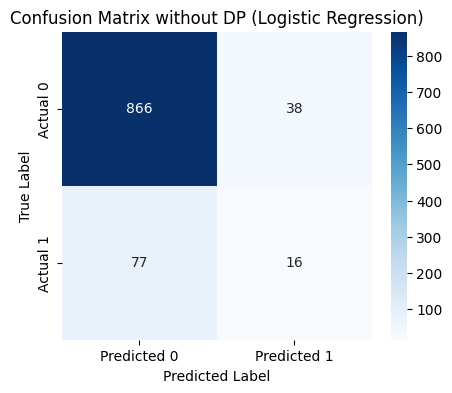

In [281]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(YResult, y_test)

# Tạo heatmap từ ma trận nhầm lẫn
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix without DP (Logistic Regression)')
plt.savefig('../static/app/images/ConfusionMatrixLogBefore.JPG')
plt.show()

In [282]:
# Chuyển đổi kết quả dự đoán thành numpy array để sử dụng với các hàm tính toán từ sklearn.metrics
YResult1 = YResult.cpu().numpy()
logResult=evaluateModel(y_test,YResult1)


auc_score = 0.6073210007462393
F1_score = 0.21768707482993196
Recall = 0.2962962962962963
Precision = 0.17204301075268819


#### 3. Mô hình Decision Tree

In [283]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
class DecisionTreeModel:
    def __init__(self, x_train, y_train, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None, criterion="entropy"):
        self.x_train = x_train
        self.y_train = y_train
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.criterion = criterion
        self.model = None

    def train(self):
        self._train_with_random_search()
    def _train_with_random_search(self):
        param_dist = {
            'max_depth': [2, 3, 5, 7,9,10],
            'min_samples_leaf': [5, 10, 20, 50, 100],
            'criterion': ["gini", "entropy"],
            'min_samples_split': [2,4, 5,6, 10]
        }

        dt_classifier = DecisionTreeClassifier()
        scorer = make_scorer(f1_score)
        random_search = RandomizedSearchCV(
            dt_classifier, param_distributions=param_dist, n_iter=50, cv=5, scoring=scorer, random_state=42)

        random_search.fit(self.x_train, self.y_train)

        self.model = random_search.best_estimator_
        # In ra thông tin về siêu tham số tốt nhất
        print("Best Parameters:", random_search.best_params_)


    def predict(self, x_test):
        return self.model.predict(x_test)

    def get_model(self):
        return self.model

    def set_model(self, model):
        self.model = model

    def get_model_parameters(self):
        return self.model.get_params()

    def evaluate(self, x_test, y_test):
        y_pred = self.predict(x_test)
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        # Tạo heatmap từ ma trận nhầm lẫn
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Decision Tree)')
        plt.savefig('../static/app/images/ConfusionMatrixDec.JPG')
        plt.show()
        return y_pred

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 9, 'criterion': 'entropy'}


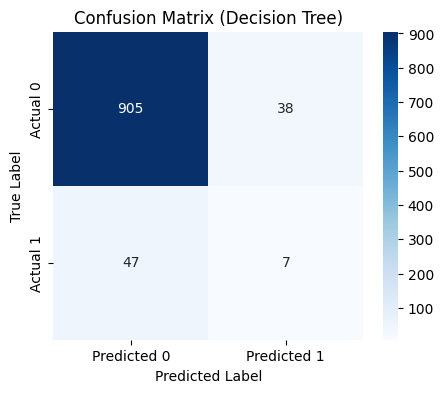

auc_score = 0.544666352460626
F1_score = 0.1414141414141414
Recall = 0.12962962962962962
Precision = 0.15555555555555556


In [284]:
modelDec = DecisionTreeModel(X_train,y_train)
modelDec.train()
yResultDes=modelDec.evaluate(X_test,y_test)
DesResult=evaluateModel(y_test,yResultDes)

#### 4. Mô hình Random Forest

In [285]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

class RandomForestModel:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.model = RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            random_state=random_state)
        self.is_trained = False

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.is_trained = True

    def predict(self, X_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before making predictions.")
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before evaluation.")
        y_pred = self.predict(X_test)
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        # Tạo heatmap từ ma trận nhầm lẫn
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Randomforest)')
        plt.savefig('../static/app/images/ConfusionMatrixRand.JPG')
        plt.show()
        return y_pred

    def get_feature_importance(self):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before getting feature importances.")
        return self.model.feature_importances_
    
    def random_search(self, X_train, y_train, param_dist, cv=5, n_iter=50, random_state=42):
        random_search = RandomizedSearchCV(self.model, param_dist, cv=cv, n_iter=n_iter, random_state=random_state)
        random_search.fit(X_train, y_train)
        self.model = random_search.best_estimator_
        self.is_trained = True

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


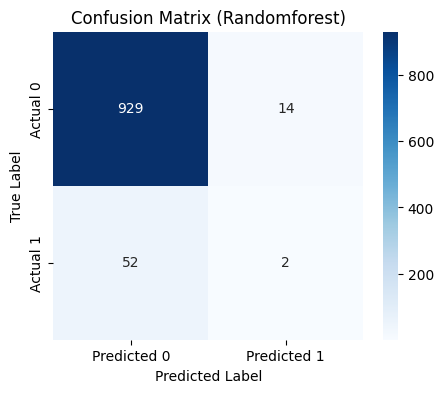

auc_score = 0.5110954008090804
F1_score = 0.05714285714285714
Recall = 0.037037037037037035
Precision = 0.125


In [286]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}
modelRand = RandomForestModel()
modelRand.random_search(X_train, y_train.ravel(), param_dist)
yResultRand= modelRand.evaluate(X_test,y_test.ravel())
RandResult = evaluateModel(y_test,yResultRand)

#### 5. Mô hình Naive Bayes

In [287]:
from sklearn.naive_bayes import GaussianNB

class NaiveBayesModel:
    def __init__(self):
        self.model = GaussianNB()
        self.is_trained = False

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.is_trained = True

    def predict(self, X_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before making predictions.")
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before evaluation.")

        y_pred = self.predict(X_test)
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        # Tạo heatmap từ ma trận nhầm lẫn
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Naive)')
        plt.savefig('../static/app/images/ConfusionMatrixNaive.JPG')
        plt.show()
        return y_pred

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


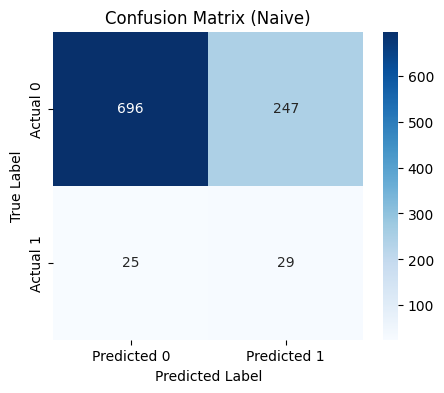

auc_score = 0.6375535132162917
F1_score = 0.17575757575757575
Recall = 0.5370370370370371
Precision = 0.10507246376811594


In [288]:
modelNaive = NaiveBayesModel()
modelNaive.train(X_train,y_train)
yResultNaive = modelNaive.evaluate(X_test,y_test)
NaiveResult = evaluateModel(y_test,yResultNaive)

### V. So sánh và đánh giá các mô hình

<Figure size 30000x2000 with 0 Axes>

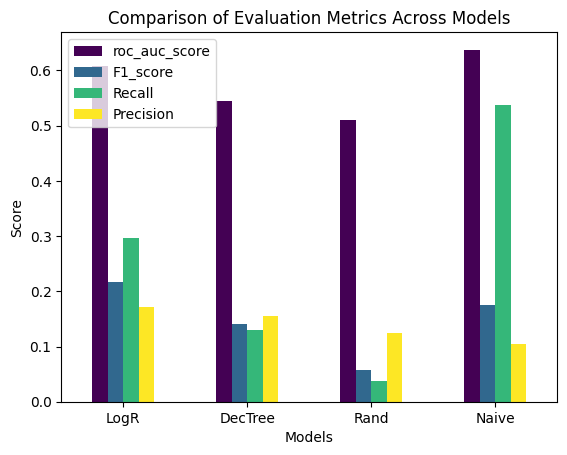

In [289]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đặt tên cho các model (có thể là tên của các biến chứa kết quả)
model_names = ['LogR', 'DecTree', 'Rand', 'Naive']

# Kết quả của hàm evaluateModel cho từng model
results = [
    logResult,DesResult,RandResult,NaiveResult
]

# Tạo DataFrame từ kết quả
df_results = pd.DataFrame(results, index=model_names)

# Vẽ biểu đồ
plt.figure(figsize=(300, 20))
df_results.plot(kind='bar', rot=0, colormap='viridis', width=0.5)
plt.title('Comparison of Evaluation Metrics Across Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.savefig("../static/app/images/ModelScoreWithoutDP.jpg")
plt.show()

In [290]:
from tabulate import tabulate
table = tabulate(df_results, headers='keys', tablefmt='pretty', showindex=True)
print(table)

+---------+--------------------+---------------------+----------------------+---------------------+
|         |   roc_auc_score    |      F1_score       |        Recall        |      Precision      |
+---------+--------------------+---------------------+----------------------+---------------------+
|  LogR   | 0.6073210007462393 | 0.21768707482993196 |  0.2962962962962963  | 0.17204301075268819 |
| DecTree | 0.544666352460626  | 0.1414141414141414  | 0.12962962962962962  | 0.15555555555555556 |
|  Rand   | 0.5110954008090804 | 0.05714285714285714 | 0.037037037037037035 |        0.125        |
|  Naive  | 0.6375535132162917 | 0.17575757575757575 |  0.5370370370370371  | 0.10507246376811594 |
+---------+--------------------+---------------------+----------------------+---------------------+


### VI. So sánh 2 mô hình tiềm năng

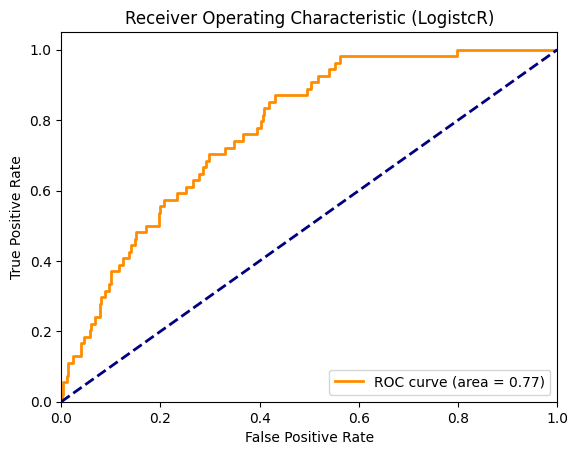

In [291]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted_Log)

# Tính AUC
roc_auc = metrics.auc(fpr, tpr)

# Vẽ đường ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (LogistcR)')
plt.legend(loc="lower right")
plt.savefig("../static/app/images/ROCLogisticRegression.png")
plt.show()

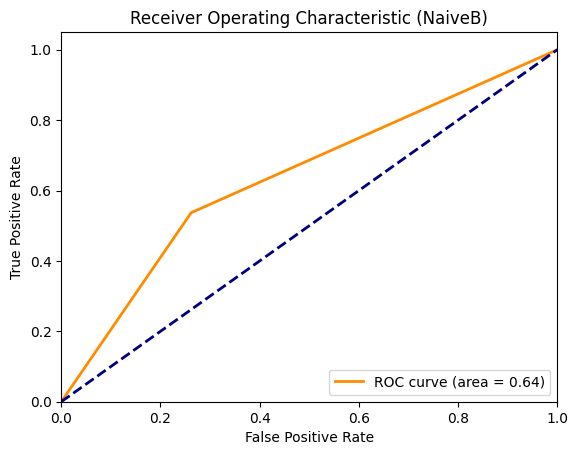

In [292]:
y_predictedNaive = modelNaive.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predictedNaive)

# Tính AUC
roc_auc = metrics.auc(fpr, tpr)

# Vẽ đường ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (NaiveB)')
plt.legend(loc="lower right")
plt.savefig("../static/app/images/ROCNaiveBayes.png")
plt.show()

### VII. Áp dụng DP vào 2 mô hình tiềm năng

In [293]:
from sklearn.metrics import accuracy_score, classification_report
from diffprivlib.models import GaussianNB as DPGaussianNB

class NaiveBayesModelDP:
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon  # Tham số epsilon cho DP
        self.model = DPGaussianNB(epsilon=self.epsilon)
        self.is_trained = False

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.is_trained = True

    def predict(self, X_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before making predictions.")
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Please train the model before evaluation.")

        y_pred = self.predict(X_test)
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(y_test, y_pred)
        # Tạo heatmap từ ma trận nhầm lẫn
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (Naive)')
        plt.show()
        return y_pred

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\diffprivlib\models\naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "


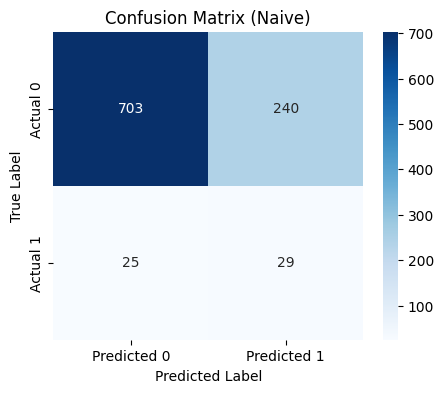

auc_score = 0.6412650720710107
F1_score = 0.17956656346749225
Recall = 0.5370370370370371
Precision = 0.10780669144981413


In [294]:
modelNaive1 = NaiveBayesModelDP()
modelNaive1.train(X_train,y_train)
yResultNaive1 = modelNaive1.evaluate(X_test,y_test)
NaiveResult1 = evaluateModel(y_test,yResultNaive1)

In [295]:
class LogisticRegressionDP:
    def __init__(self,model,X_train,y_train, X_test, y_test, EPSILON = 1.0,DELTA = 1e-5, EPOCHS = 10, MAX_GRAD_NORM = 0.1, MAX_PHYSICAL_BATCH_SIZE = 256, LOGGING_INTERVAL = 100,learning_rate=0.01, num_epochs=100):
        self.EPSILON=EPSILON
        self.DELTA=DELTA
        self.EPOCHS=EPOCHS
        self.MAX_GRAD_NORM=MAX_GRAD_NORM
        self.MAX_PHYSICAL_BATCH_SIZE = MAX_PHYSICAL_BATCH_SIZE
        self.LOGGING_INTERVAL=LOGGING_INTERVAL
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test
        self.y_test=y_test
        self.learning_rate=learning_rate
        self.model=model
        self.num_epochs=num_epochs
        self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.status=False
    def preTrain(self):
        train_dataset = TensorDataset(self.X_train, self.y_train)
        train_dataloader = DataLoader(train_dataset, batch_size=self.MAX_PHYSICAL_BATCH_SIZE, shuffle=True)
        model = self.model.to(self.device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(model.parameters(),lr=self.learning_rate)
        model = model.train()
        return train_dataloader,model,optimizer,criterion
    def train_model(self):
        from opacus import PrivacyEngine
        
        privacy_engine = PrivacyEngine()
        train_dataloader,model,optimizer,criterion= self.preTrain()
        model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            target_delta=self.DELTA,
            target_epsilon=self.EPSILON, 
            epochs=self.EPOCHS,
            max_grad_norm=self.MAX_GRAD_NORM,
        )
        print(f"Training with hyperparameters:")
        print(f"  EPSILON: {self.EPSILON}")
        print(f"  DELTA: {self.DELTA}")
        print(f"  EPOCHS: {self.EPOCHS}")
        print(f"  MAX_GRAD_NORM: {self.MAX_GRAD_NORM}")
        print(f"  MAX_PHYSICAL_BATCH_SIZE: {self.MAX_PHYSICAL_BATCH_SIZE}")
        print(f"  LOGGING_INTERVAL: {self.LOGGING_INTERVAL}")
        print(f"  learning_rate: {self.learning_rate}")
        print(f"  num_epochs: {self.num_epochs}")
        num_epochs = self.num_epochs
        lossesLogDP = []  # Danh sách lưu giữ giá trị loss
        epsilons = []  # Danh sách lưu giữ giá trị epsilon

        for epoch in range(num_epochs):
            for step,(X_batch, y_batch) in enumerate(data_loader):
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_predicted = model(X_batch)
                loss = criterion(y_predicted,y_batch)
                
                loss.backward()
                
                optimizer.step()
                
                optimizer.zero_grad()
                
                if step >= 0 and step % self.LOGGING_INTERVAL == 0:
                    eps = privacy_engine.get_epsilon(self.DELTA)
                    if(epoch+1) % 10 ==0:
                        print(f"epoch: {epoch+1}, loss={loss.item():.4f}  | ɛ: {eps:.2f} ")
                        
                    lossesLogDP.append(loss.item())
                    epsilons.append(eps)
        with torch.no_grad():
            y_predicted = model(self.X_test.to(self.device))
            y_predicted_cls = y_predicted.round()
            evalLogDP=evaluateModel(y_predicted_cls,y_test)
            print(evalLogDP)
        if self.status == True:
            torch.save(model, './StruckPredict.pth')
        epochs = range(1, num_epochs + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, lossesLogDP, label='Loss', marker='o')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, epsilons, label='Epsilon', marker='o')
        plt.title('Epsilon Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Epsilon')
        plt.legend()

        plt.tight_layout()
        plt.savefig('../static/app/images/epsilonAndLoss.JPG')
        plt.show()
        return lossesLogDP,epsilons,y_predicted
    def predict_model(self, X):
        with torch.no_grad():
            y_predicted = self.model(X.to(self.device))
            y_predicted_cls = y_predicted.round()
            return y_predicted_cls
    def train_model_for_grid(self):
        from opacus import PrivacyEngine
        
        privacy_engine = PrivacyEngine()
        train_dataloader,model,optimizer,criterion= self.preTrain()
        model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            target_delta=self.DELTA,
            target_epsilon=self.EPSILON, 
            epochs=self.EPOCHS,
            max_grad_norm=self.MAX_GRAD_NORM,
        )
        num_epochs = self.num_epochs
        for epoch in range(num_epochs):
            for step,(X_batch, y_batch) in enumerate(data_loader):
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_predicted = model(X_batch)
                loss = criterion(y_predicted,y_batch)
                
                loss.backward()
                
                optimizer.step()
                
                optimizer.zero_grad()
        with torch.no_grad():
            y_predicted = model(self.X_test.to(self.device))
            y_predicted_cls = y_predicted.round()
            eval = evaluateModel(y_predicted_cls,y_test)
            auc,f1= eval['roc_auc_score'], eval['F1_score']
        return auc,f1
    def grid_search(self,num_features):
        from sklearn.model_selection import ParameterGrid
        bestAuc = 0
        bestF1 = 0
        best_params = None
        param_grid = {
        'EPSILON': [1.0, 0.5],
        'DELTA': [1e-5, 1e-6],
        'EPOCHS': [10, 20],
        'MAX_GRAD_NORM': [0.1, 0.2],
        'MAX_PHYSICAL_BATCH_SIZE': [256, 512],
        'LOGGING_INTERVAL': [100, 200],
        'learning_rate': [0.01, 0.001],
        'num_epochs': [50, 100]
        }
        all_params = list(ParameterGrid(param_grid))
        total_combinations = len(all_params)

        for i, params in enumerate(all_params, 1):
            print(f"Training model {i}/{total_combinations} with parameters: {params}")
            modelTemp=LogisticRegression(num_features)
            logDPTemp=LogisticRegressionDP(modelTemp,X_train,y_train,X_test,y_test,params['EPSILON'],params['DELTA'],params['EPOCHS'],params['MAX_GRAD_NORM'],
                                           params['MAX_PHYSICAL_BATCH_SIZE'],params['LOGGING_INTERVAL'],params['learning_rate'],params['num_epochs'],)
            auc,f1 = logDPTemp.train_model_for_grid()

            if auc > 0.5 and f1 > 0.1:
                if auc > bestAuc and f1 > bestF1:
                    bestAuc= auc
                    bestF1 = f1
                    best_params = params
        if best_params != None:
            print("Grid search finished.")
            print(f"Best AUC: {bestAuc:.4f}")
            print("Best parameters:", best_params)
            self.update_parameters(best_params)
    
    def update_parameters(self, new_params):
        # Update the model parameters with the new_params
        self.EPSILON = new_params['EPSILON']
        self.DELTA = new_params['DELTA']
        self.EPOCHS = new_params['EPOCHS']
        self.MAX_GRAD_NORM = new_params['MAX_GRAD_NORM']
        self.MAX_PHYSICAL_BATCH_SIZE = new_params['MAX_PHYSICAL_BATCH_SIZE']
        self.LOGGING_INTERVAL = new_params['LOGGING_INTERVAL']
        self.learning_rate = new_params['learning_rate']
        self.num_epochs = new_params['num_epochs']
        self.status=True

In [296]:
model2=LogisticRegression(num_features)
logDP=LogisticRegressionDP(model2,X_train,y_train,X_test,y_test)
#logDP.train_model()

In [297]:
logDP.grid_search(num_features)

Training model 1/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5416957296752694
F1_score = 0.1917808219178082
Recall = 0.11764705882352941
Precision = 0.5185185185185185
Training model 2/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5210855620952903
F1_score = 0.14153846153846156
Recall = 0.08487084870848709
Precision = 0.42592592592592593
Training model 3/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48832492514663056
F1_score = 0.08051529790660225
Recall = 0.04409171075837742
Precision = 0.46296296296296297
Training model 4/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5159598906989303
F1_score = 0.1258741258741259
Recall = 0.0694980694980695
Precision = 0.6666666666666666
Training model 5/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5144849612552961
F1_score = 0.1234567901234568
Recall = 0.0682261208576998
Precision = 0.6481481481481481
Training model 6/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5000916170407695
F1_score = 0.09937888198757763
Recall = 0.05423728813559322
Precision = 0.5925925925925926
Training model 7/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5099757748428584
F1_score = 0.11573236889692586
Recall = 0.06412825651302605
Precision = 0.5925925925925926
Training model 8/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4899772305616461
F1_score = 0.0849772382397572
Recall = 0.04628099173553719
Precision = 0.5185185185185185
Training model 9/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.538774542533941
F1_score = 0.1839080459770115
Recall = 0.10884353741496598
Precision = 0.5925925925925926
Training model 10/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5527303217176635
F1_score = 0.21764705882352942
Recall = 0.12937062937062938
Precision = 0.6851851851851852
Training model 11/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5160181147266019
F1_score = 0.12923076923076923
Recall = 0.07749077490774908
Precision = 0.3888888888888889
Training model 12/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5295056459500311
F1_score = 0.16040100250626566
Recall = 0.0927536231884058
Precision = 0.5925925925925926
Training model 13/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5503744650499286
F1_score = 0.21142857142857144
Recall = 0.125
Precision = 0.6851851851851852
Training model 14/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5178114067966018
F1_score = 0.13333333333333333
Recall = 0.08045977011494253
Precision = 0.3888888888888889
Training model 15/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49017259670311736
F1_score = 0.07692307692307693
Recall = 0.04318181818181818
Precision = 0.35185185185185186
Training model 16/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.47353140971728025
F1_score = 0.04633204633204634
Recall = 0.02586206896551724
Precision = 0.2222222222222222
Training model 17/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4884855817705182
F1_score = 0.07561436672967864
Recall = 0.042105263157894736
Precision = 0.37037037037037035
Training model 18/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5442082878457061
F1_score = 0.1978798586572438
Recall = 0.1222707423580786
Precision = 0.5185185185185185
Training model 19/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5201145262412374
F1_score = 0.13405797101449274
Recall = 0.07429718875502007
Precision = 0.6851851851851852
Training model 20/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.528705213428655
F1_score = 0.14175654853620956
Recall = 0.0773109243697479
Precision = 0.8518518518518519
Training model 21/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5251504090952751
F1_score = 0.15012106537530268
Recall = 0.08635097493036212
Precision = 0.5740740740740741
Training model 22/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5176636716315905
F1_score = 0.13333333333333333
Recall = 0.07971014492753623
Precision = 0.4074074074074074
Training model 23/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4878524901889388
F1_score = 0.07364341085271318
Recall = 0.04112554112554113
Precision = 0.35185185185185186
Training model 24/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5081544581940453
F1_score = 0.1107871720116618
Recall = 0.0657439446366782
Precision = 0.35185185185185186
Training model 25/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5165637282425604
F1_score = 0.1311475409836066
Recall = 0.07692307692307693
Precision = 0.4444444444444444
Training model 26/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5599215854881969
F1_score = 0.2360248447204969
Recall = 0.1417910447761194
Precision = 0.7037037037037037
Training model 27/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5313564440149776
F1_score = 0.15526802218114602
Recall = 0.08624229979466119
Precision = 0.7777777777777778
Training model 28/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5165995813227937
F1_score = 0.12649572649572652
Recall = 0.0696798493408663
Precision = 0.6851851851851852
Training model 29/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5171453656089302
F1_score = 0.13157894736842105
Recall = 0.07462686567164178
Precision = 0.5555555555555556
Training model 30/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5006289446970031
F1_score = 0.08294930875576037
Recall = 0.05521472392638037
Precision = 0.16666666666666666
Training model 31/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5064233683738111
F1_score = 0.10850439882697947
Recall = 0.0589171974522293
Precision = 0.6851851851851852
Training model 32/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48435565460398317
F1_score = 0.07977207977207977
Recall = 0.043209876543209874
Precision = 0.5185185185185185
Training model 33/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5199910777395395
F1_score = 0.13718411552346568
Recall = 0.08520179372197309
Precision = 0.35185185185185186
Training model 34/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5447908919274558
F1_score = 0.199288256227758
Recall = 0.12334801762114538
Precision = 0.5185185185185185
Training model 35/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5180883219982894
F1_score = 0.13333333333333333
Recall = 0.07542579075425791
Precision = 0.5740740740740741
Training model 36/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5220856605651717
F1_score = 0.144
Recall = 0.08411214953271028
Precision = 0.5
Training model 37/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5055987319766848
F1_score = 0.10746268656716419
Recall = 0.05844155844155844
Precision = 0.6666666666666666
Training model 38/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5043591633127374
F1_score = 0.09859154929577466
Recall = 0.06086956521739131
Precision = 0.25925925925925924
Training model 39/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5198969636106825
F1_score = 0.13071895424836602
Recall = 0.07168458781362007
Precision = 0.7407407407407407
Training model 40/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4838603425559947
F1_score = 0.08044382801664356
Recall = 0.043478260869565216
Precision = 0.5370370370370371
Training model 41/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5172624953491257
F1_score = 0.1320754716981132
Recall = 0.07954545454545454
Precision = 0.3888888888888889
Training model 42/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5435983781848442
F1_score = 0.19540229885057472
Recall = 0.11564625850340136
Precision = 0.6296296296296297
Training model 43/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.509072379744542
F1_score = 0.1139896373056995
Recall = 0.06626506024096386
Precision = 0.4074074074074074
Training model 44/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4952108516372674
F1_score = 0.08996539792387544
Recall = 0.04961832061068702
Precision = 0.48148148148148145
Training model 45/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5019703038394627
F1_score = 0.10077519379844961
Recall = 0.05627705627705628
Precision = 0.48148148148148145
Training model 46/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5394943028848157
F1_score = 0.1782608695652174
Recall = 0.10098522167487685
Precision = 0.7592592592592593
Training model 47/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5288191610902563
F1_score = 0.15384615384615385
Recall = 0.08636363636363636
Precision = 0.7037037037037037
Training model 48/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4975376344086021
F1_score = 0.0892018779342723
Recall = 0.051075268817204304
Precision = 0.35185185185185186
Training model 49/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5202619464436231
F1_score = 0.13978494623655913
Recall = 0.08176100628930817
Precision = 0.48148148148148145
Training model 50/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5438572757651705
F1_score = 0.19553072625698326
Recall = 0.11513157894736842
Precision = 0.6481481481481481
Training model 51/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5082103512783205
F1_score = 0.10937499999999999
Recall = 0.058823529411764705
Precision = 0.7777777777777778
Training model 52/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4865354603780128
F1_score = 0.08163265306122448
Recall = 0.04430379746835443
Precision = 0.5185185185185185
Training model 53/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4926438053097345
F1_score = 0.08723747980613894
Recall = 0.047787610619469026
Precision = 0.5
Training model 54/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48249598876855193
F1_score = 0.04833836858006043
Recall = 0.02888086642599278
Precision = 0.14814814814814814
Training model 55/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4896250941516631
F1_score = 0.08108108108108107
Recall = 0.04460966542750929
Precision = 0.4444444444444444
Training model 56/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5086073549224092
F1_score = 0.11214953271028037
Recall = 0.061224489795918366
Precision = 0.6666666666666666
Training model 57/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5525444925444926
F1_score = 0.21652421652421652
Recall = 0.12794612794612795
Precision = 0.7037037037037037
Training model 58/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5506036022985176
F1_score = 0.21203438395415472
Recall = 0.12542372881355932
Precision = 0.6851851851851852
Training model 59/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49646041008185426
F1_score = 0.09001956947162426
Recall = 0.05032822757111598
Precision = 0.42592592592592593
Training model 60/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.497097677303627
F1_score = 0.0950920245398773
Recall = 0.051839464882943144
Precision = 0.5740740740740741
Training model 61/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5206592956592957
F1_score = 0.1386861313868613
Recall = 0.08636363636363636
Precision = 0.35185185185185186
Training model 62/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5500417136968151
F1_score = 0.21114369501466276
Recall = 0.1254355400696864
Precision = 0.6666666666666666
Training model 63/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.46461708241369254
F1_score = 0.021691973969631236
Recall = 0.012285012285012284
Precision = 0.09259259259259259
Training model 64/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5380664011343828
F1_score = 0.18041237113402062
Recall = 0.10479041916167664
Precision = 0.6481481481481481
Training model 65/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5126084417751084
F1_score = 0.12200435729847493
Recall = 0.0691358024691358
Precision = 0.5185185185185185
Training model 66/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5430289223155957
F1_score = 0.18867924528301888
Recall = 0.12658227848101267
Precision = 0.37037037037037035
Training model 67/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5122781983376464
F1_score = 0.12030075187969924
Recall = 0.06694560669456066
Precision = 0.5925925925925926
Training model 68/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49502398081534776
F1_score = 0.0914826498422713
Recall = 0.05
Precision = 0.5370370370370371
Training model 69/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5172172289015992
F1_score = 0.1326530612244898
Recall = 0.07692307692307693
Precision = 0.48148148148148145
Training model 70/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.509068766745149
F1_score = 0.11352253756260434
Recall = 0.062385321100917435
Precision = 0.6296296296296297
Training model 71/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5327587401383873
F1_score = 0.16666666666666666
Recall = 0.09562841530054644
Precision = 0.6481481481481481
Training model 72/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.50951440072803
F1_score = 0.11546391752577319
Recall = 0.06496519721577726
Precision = 0.5185185185185185
Training model 73/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5094526064583489
F1_score = 0.11538461538461539
Recall = 0.06521739130434782
Precision = 0.5
Training model 74/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5662820436566942
F1_score = 0.2527881040892193
Recall = 0.15813953488372093
Precision = 0.6296296296296297
Training model 75/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5172397424611188
F1_score = 0.132387706855792
Recall = 0.07588075880758807
Precision = 0.5185185185185185
Training model 76/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5101457716104091
F1_score = 0.11685393258426968
Recall = 0.06649616368286446
Precision = 0.48148148148148145
Training model 77/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5216665493639259
F1_score = 0.14250614250614252
Recall = 0.0821529745042493
Precision = 0.5370370370370371
Training model 78/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5172321013031338
F1_score = 0.1325648414985591
Recall = 0.07849829351535836
Precision = 0.42592592592592593
Training model 79/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5350360262448174
F1_score = 0.16176470588235295
Recall = 0.08979591836734693
Precision = 0.8148148148148148
Training model 80/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48067892062443823
F1_score = 0.07702888583218707
Recall = 0.041604754829123326
Precision = 0.5185185185185185
Training model 81/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5085292497987884
F1_score = 0.11337868480725621
Recall = 0.06459948320413436
Precision = 0.46296296296296297
Training model 82/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5239001215832845
F1_score = 0.14084507042253522
Recall = 0.09433962264150944
Precision = 0.2777777777777778
Training model 83/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5225388262931222
F1_score = 0.14423076923076922
Recall = 0.08287292817679558
Precision = 0.5555555555555556
Training model 84/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5312295618051014
F1_score = 0.15544041450777202
Recall = 0.1079136690647482
Precision = 0.2777777777777778
Training model 85/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.508347516505924
F1_score = 0.11199999999999999
Recall = 0.06129597197898424
Precision = 0.6481481481481481
Training model 86/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5326337048777994
F1_score = 0.16551724137931037
Recall = 0.09448818897637795
Precision = 0.6666666666666666
Training model 87/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48262424828920997
F1_score = 0.0761346998535871
Recall = 0.04133545310015898
Precision = 0.48148148148148145
Training model 88/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5012501509844184
F1_score = 0.09981515711645102
Recall = 0.055441478439425054
Precision = 0.5
Training model 89/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5228095280518498
F1_score = 0.14482758620689656
Recall = 0.08898305084745763
Precision = 0.3888888888888889
Training model 90/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5518785415126879
F1_score = 0.21621621621621623
Recall = 0.13658536585365855
Precision = 0.5185185185185185
Training model 91/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4743845085273394
F1_score = 0.061538461538461535
Recall = 0.03355704697986577
Precision = 0.37037037037037035
Training model 92/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49884059030400496
F1_score = 0.09666666666666665
Recall = 0.05311355311355311
Precision = 0.5370370370370371
Training model 93/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.510628179064508
F1_score = 0.11764705882352942
Recall = 0.06605922551252848
Precision = 0.5370370370370371
Training model 94/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5411309400085123
F1_score = 0.18991097922848665
Recall = 0.11307420494699646
Precision = 0.5925925925925926
Training model 95/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5045904338073013
F1_score = 0.10584958217270193
Recall = 0.0572289156626506
Precision = 0.7037037037037037
Training model 96/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5144349501136026
F1_score = 0.12552301255230125
Recall = 0.07075471698113207
Precision = 0.5555555555555556
Training model 97/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5312626817511457
F1_score = 0.16617210682492578
Recall = 0.0989399293286219
Precision = 0.5185185185185185
Training model 98/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5287127401192316
F1_score = 0.15841584158415842
Recall = 0.09142857142857143
Precision = 0.5925925925925926
Training model 99/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5105297830748431
F1_score = 0.1176470588235294
Recall = 0.0673854447439353
Precision = 0.46296296296296297
Training model 100/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4891184237253707
F1_score = 0.0753968253968254
Recall = 0.042222222222222223
Precision = 0.35185185185185186
Training model 101/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5350482932046603
F1_score = 0.1663286004056795
Recall = 0.09339407744874716
Precision = 0.7592592592592593
Training model 102/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5285431396846222
F1_score = 0.15204678362573099
Recall = 0.08496732026143791
Precision = 0.7222222222222222
Training model 103/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5259887087017887
F1_score = 0.15340909090909088
Recall = 0.09060402684563758
Precision = 0.5
Training model 104/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.47448453397287405
F1_score = 0.04508196721311476
Recall = 0.02534562211981567
Precision = 0.2037037037037037
Training model 105/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.536641325006788
F1_score = 0.16574585635359115
Recall = 0.11811023622047244
Precision = 0.2777777777777778
Training model 106/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5331681884955497
F1_score = 0.17045454545454544
Recall = 0.10067114093959731
Precision = 0.5555555555555556
Training model 107/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.51003663003663
F1_score = 0.11609498680738788
Recall = 0.06769230769230769
Precision = 0.4074074074074074
Training model 108/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5303375422959479
F1_score = 0.14580031695721077
Recall = 0.07972270363951472
Precision = 0.8518518518518519
Training model 109/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49445589705147425
F1_score = 0.07619047619047618
Recall = 0.04597701149425287
Precision = 0.2222222222222222
Training model 110/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5445966953633805
F1_score = 0.19852941176470587
Recall = 0.12385321100917432
Precision = 0.5
Training model 111/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5178604520001612
F1_score = 0.13059701492537315
Recall = 0.07261410788381743
Precision = 0.6481481481481481
Training model 112/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4715340657571733
F1_score = 0.046762589928057555
Recall = 0.025896414342629483
Precision = 0.24074074074074073
Training model 113/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5137111429937828
F1_score = 0.12429378531073447
Recall = 0.07333333333333333
Precision = 0.4074074074074074
Training model 114/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5477617184971473
F1_score = 0.2037533512064343
Recall = 0.11912225705329153
Precision = 0.7037037037037037
Training model 115/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5048738043663445
F1_score = 0.10629921259842519
Recall = 0.05947136563876652
Precision = 0.5
Training model 116/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.46970259901845585
F1_score = 0.05856515373352854
Recall = 0.03179650238473768
Precision = 0.37037037037037035
Training model 117/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5006100625871518
F1_score = 0.09803921568627451
Recall = 0.05482456140350877
Precision = 0.46296296296296297
Training model 118/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5402998236331569
F1_score = 0.17768595041322316
Recall = 0.1
Precision = 0.7962962962962963
Training model 119/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5141642089316507
F1_score = 0.12280701754385964
Recall = 0.06782945736434108
Precision = 0.6481481481481481
Training model 120/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.47430441313210786
F1_score = 0.0676056338028169
Recall = 0.036585365853658534
Precision = 0.4444444444444444
Training model 121/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5423444485459988
F1_score = 0.18181818181818182
Recall = 0.10232558139534884
Precision = 0.8148148148148148
Training model 122/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5313787904171553
F1_score = 0.16608996539792387
Recall = 0.10212765957446808
Precision = 0.4444444444444444
Training model 123/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5356611854066502
F1_score = 0.16506717850287908
Recall = 0.09207708779443255
Precision = 0.7962962962962963
Training model 124/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5208171190453027
F1_score = 0.13725490196078433
Recall = 0.07675438596491228
Precision = 0.6481481481481481
Training model 125/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5427291606297692
F1_score = 0.17550274223034737
Recall = 0.0973630831643002
Precision = 0.8888888888888888
Training model 126/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5330690241827682
F1_score = 0.1674641148325359
Recall = 0.09615384615384616
Precision = 0.6481481481481481
Training model 127/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5358152473333875
F1_score = 0.17525773195876287
Recall = 0.10179640718562874
Precision = 0.6296296296296297
Training model 128/256 with parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5297885060590386
F1_score = 0.1590909090909091
Recall = 0.09067357512953368
Precision = 0.6481481481481481
Training model 129/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5290562538635896
F1_score = 0.15546218487394958
Recall = 0.08767772511848342
Precision = 0.6851851851851852
Training model 130/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5569865310874464
F1_score = 0.22950819672131145
Recall = 0.1394422310756972
Precision = 0.6481481481481481
Training model 131/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4949679251235672
F1_score = 0.07717041800643087
Recall = 0.04669260700389105
Precision = 0.2222222222222222
Training model 132/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.522235390906277
F1_score = 0.14056224899598393
Recall = 0.07882882882882883
Precision = 0.6481481481481481
Training model 133/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5493251395462923
F1_score = 0.20833333333333334
Recall = 0.13440860215053763
Precision = 0.46296296296296297
Training model 134/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5199677716015724
F1_score = 0.136
Recall = 0.07623318385650224
Precision = 0.6296296296296297
Training model 135/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4842361319279598
F1_score = 0.06640625000000001
Recall = 0.03711790393013101
Precision = 0.3148148148148148
Training model 136/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48710362863680945
F1_score = 0.0781758957654723
Recall = 0.04285714285714286
Precision = 0.4444444444444444
Training model 137/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5480405756892666
F1_score = 0.20047732696897375
Recall = 0.11506849315068493
Precision = 0.7777777777777778
Training model 138/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5542745334136062
F1_score = 0.22297297297297294
Recall = 0.13636363636363635
Precision = 0.6111111111111112
Training model 139/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48990322554122157
F1_score = 0.08320000000000001
Recall = 0.04553415061295972
Precision = 0.48148148148148145
Training model 140/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.481028474959666
F1_score = 0.056155507559395246
Recall = 0.03178484107579462
Precision = 0.24074074074074073
Training model 141/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5492639158963978
F1_score = 0.20500000000000002
Recall = 0.11849710982658959
Precision = 0.7592592592592593
Training model 142/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5347606072401713
F1_score = 0.171021377672209
Recall = 0.09809264305177112
Precision = 0.6666666666666666
Training model 143/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5321715928770892
F1_score = 0.1623931623931624
Recall = 0.09178743961352658
Precision = 0.7037037037037037
Training model 144/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5050058965161417
F1_score = 0.10679611650485436
Recall = 0.05851063829787234
Precision = 0.6111111111111112
Training model 145/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5126066825293291
F1_score = 0.12201591511936341
Recall = 0.07120743034055728
Precision = 0.42592592592592593
Training model 146/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5262903578211399
F1_score = 0.1511111111111111
Recall = 0.08585858585858586
Precision = 0.6296296296296297
Training model 147/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4757368227956463
F1_score = 0.04838709677419355
Recall = 0.027149321266968326
Precision = 0.2222222222222222
Training model 148/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4739260323702919
F1_score = 0.04
Recall = 0.022727272727272728
Precision = 0.16666666666666666
Training model 149/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.510566659798063
F1_score = 0.11764705882352942
Recall = 0.06635071090047394
Precision = 0.5185185185185185
Training model 150/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49318552405109156
F1_score = 0.0917941585535466
Recall = 0.04962406015037594
Precision = 0.6111111111111112
Training model 151/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5182942371097572
F1_score = 0.13333333333333333
Recall = 0.07511737089201878
Precision = 0.5925925925925926
Training model 152/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.500183276908757
F1_score = 0.09643605870020965
Recall = 0.054373522458628844
Precision = 0.42592592592592593
Training model 153/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49841108857336036
F1_score = 0.08391608391608392
Recall = 0.05172413793103448
Precision = 0.2222222222222222
Training model 154/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5353633999116651
F1_score = 0.1759530791788856
Recall = 0.10452961672473868
Precision = 0.5555555555555556
Training model 155/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48951235913182256
F1_score = 0.08094435075885328
Recall = 0.04452690166975881
Precision = 0.4444444444444444
Training model 156/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49348993288590604
F1_score = 0.08383233532934133
Recall = 0.04697986577181208
Precision = 0.3888888888888889
Training model 157/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.534201175021321
F1_score = 0.17270194986072424
Recall = 0.10163934426229508
Precision = 0.5740740740740741
Training model 158/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.53927856530087
F1_score = 0.18575851393188855
Recall = 0.11152416356877323
Precision = 0.5555555555555556
Training model 159/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5103749058483368
F1_score = 0.11695906432748539
Recall = 0.06535947712418301
Precision = 0.5555555555555556
Training model 160/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49547585031456004
F1_score = 0.09259259259259259
Recall = 0.050505050505050504
Precision = 0.5555555555555556
Training model 161/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5259901845579595
F1_score = 0.15165876777251186
Recall = 0.08695652173913043
Precision = 0.5925925925925926
Training model 162/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5242085513450663
F1_score = 0.14886731391585759
Recall = 0.09019607843137255
Precision = 0.42592592592592593
Training model 163/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4978098939357137
F1_score = 0.09475465313028765
Recall = 0.0521415270018622
Precision = 0.5185185185185185
Training model 164/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48421532685121227
F1_score = 0.07965860597439545
Recall = 0.04314329738058552
Precision = 0.5185185185185185
Training model 165/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49068261651456324
F1_score = 0.07555555555555556
Recall = 0.04292929292929293
Precision = 0.3148148148148148
Training model 166/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5322980857197106
F1_score = 0.16548463356973997
Recall = 0.0948509485094851
Precision = 0.6481481481481481
Training model 167/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5314698619943174
F1_score = 0.16252821670428894
Recall = 0.09254498714652956
Precision = 0.6666666666666666
Training model 168/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5109144609279884
F1_score = 0.11825192802056556
Recall = 0.06865671641791045
Precision = 0.42592592592592593
Training model 169/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5449170406636746
F1_score = 0.19658119658119655
Recall = 0.12777777777777777
Precision = 0.42592592592592593
Training model 170/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5514871070995447
F1_score = 0.21492537313432836
Recall = 0.12811387900355872
Precision = 0.6666666666666666
Training model 171/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.491487739542551
F1_score = 0.08585055643879172
Recall = 0.04695652173913043
Precision = 0.5
Training model 172/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5150382769982905
F1_score = 0.12684989429175475
Recall = 0.07159904534606205
Precision = 0.5555555555555556
Training model 173/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5230624214495182
F1_score = 0.14634146341463414
Recall = 0.08571428571428572
Precision = 0.5
Training model 174/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5266848154869933
F1_score = 0.14744801512287334
Recall = 0.08210526315789474
Precision = 0.7222222222222222
Training model 175/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.506402952642159
F1_score = 0.10909090909090909
Recall = 0.05989110707803993
Precision = 0.6111111111111112
Training model 176/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5131709334512636
F1_score = 0.1197411003236246
Recall = 0.06560283687943262
Precision = 0.6851851851851852
Training model 177/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.523266806722689
F1_score = 0.14598540145985403
Recall = 0.08403361344537816
Precision = 0.5555555555555556
Training model 178/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5073194794290512
F1_score = 0.11086474501108647
Recall = 0.06297229219143577
Precision = 0.46296296296296297
Training model 179/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4918357487922706
F1_score = 0.09053497942386833
Recall = 0.04888888888888889
Precision = 0.6111111111111112
Training model 180/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.488361968887857
F1_score = 0.08150470219435736
Recall = 0.04452054794520548
Precision = 0.48148148148148145
Training model 181/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5124885043907123
F1_score = 0.1190082644628099
Recall = 0.06533575317604355
Precision = 0.6666666666666666
Training model 182/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5671656686626747
F1_score = 0.25
Recall = 0.16666666666666666
Precision = 0.5
Training model 183/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5236933181433724
F1_score = 0.14657210401891252
Recall = 0.08401084010840108
Precision = 0.5740740740740741
Training model 184/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5217177990311762
F1_score = 0.14072494669509594
Recall = 0.07951807228915662
Precision = 0.6111111111111112
Training model 185/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49487015231936227
F1_score = 0.0606060606060606
Recall = 0.04504504504504504
Precision = 0.09259259259259259
Training model 186/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5316647386686297
F1_score = 0.16720257234726688
Recall = 0.10116731517509728
Precision = 0.48148148148148145
Training model 187/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5032559753401223
F1_score = 0.10380622837370242
Recall = 0.05725190839694656
Precision = 0.5555555555555556
Training model 188/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5037533523812863
F1_score = 0.10243902439024391
Recall = 0.05898876404494382
Precision = 0.3888888888888889
Training model 189/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.508260649087221
F1_score = 0.11042944785276074
Recall = 0.0661764705882353
Precision = 0.3333333333333333
Training model 190/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5255986082139915
F1_score = 0.15121951219512195
Recall = 0.08707865168539326
Precision = 0.5740740740740741
Training model 191/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5061401246161162
F1_score = 0.10881801125703566
Recall = 0.060542797494780795
Precision = 0.5370370370370371
Training model 192/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 10, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4821043677895137
F1_score = 0.059196617336152224
Recall = 0.03341288782816229
Precision = 0.25925925925925924
Training model 193/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5445431188561216
F1_score = 0.1920374707259953
Recall = 0.10991957104557641
Precision = 0.7592592592592593
Training model 194/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5468054701349444
F1_score = 0.20377358490566036
Recall = 0.12796208530805686
Precision = 0.5
Training model 195/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5139249525707941
F1_score = 0.11832611832611832
Recall = 0.06416275430359937
Precision = 0.7592592592592593
Training model 196/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.477898788214928
F1_score = 0.06717557251908397
Recall = 0.036605657237936774
Precision = 0.4074074074074074
Training model 197/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5167121765898086
F1_score = 0.12330827067669173
Recall = 0.06710310965630115
Precision = 0.7592592592592593
Training model 198/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5109752408052461
F1_score = 0.11836734693877553
Recall = 0.06651376146788991
Precision = 0.5370370370370371
Training model 199/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5084343924326946
F1_score = 0.11262798634812286
Recall = 0.06203007518796992
Precision = 0.6111111111111112
Training model 200/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5009848796751512
F1_score = 0.09904761904761905
Recall = 0.055201698513800426
Precision = 0.48148148148148145
Training model 201/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.537610294792068
F1_score = 0.17989417989417988
Recall = 0.10493827160493827
Precision = 0.6296296296296297
Training model 202/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5385953346855984
F1_score = 0.18404907975460122
Recall = 0.11029411764705882
Precision = 0.5555555555555556
Training model 203/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.46935845763909084
F1_score = 0.0530421216848674
Recall = 0.028960817717206135
Precision = 0.3148148148148148
Training model 204/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4979952450032237
F1_score = 0.09363295880149813
Recall = 0.052083333333333336
Precision = 0.46296296296296297
Training model 205/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5424792343806428
F1_score = 0.18219461697722567
Recall = 0.10256410256410256
Precision = 0.8148148148148148
Training model 206/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5590076518412243
F1_score = 0.23163841807909602
Recall = 0.13666666666666666
Precision = 0.7592592592592593
Training model 207/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5297998217035417
F1_score = 0.14814814814814814
Recall = 0.08148148148148149
Precision = 0.8148148148148148
Training model 208/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49442520606740475
F1_score = 0.09461235216819974
Recall = 0.05091937765205092
Precision = 0.6666666666666666
Training model 209/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5086880227001195
F1_score = 0.10280373831775702
Recall = 0.06875
Precision = 0.2037037037037037
Training model 210/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5492692685904175
F1_score = 0.21052631578947364
Recall = 0.12987012987012986
Precision = 0.5555555555555556
Training model 211/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5254539466147325
F1_score = 0.15211267605633802
Recall = 0.08970099667774087
Precision = 0.5
Training model 212/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48092074236413573
F1_score = 0.0482573726541555
Recall = 0.02821316614420063
Precision = 0.16666666666666666
Training model 213/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48504461399198234
F1_score = 0.07929515418502203
Recall = 0.0430622009569378
Precision = 0.5
Training model 214/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.488663910230094
F1_score = 0.0641399416909621
Recall = 0.03806228373702422
Precision = 0.2037037037037037
Training model 215/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4880312652662433
F1_score = 0.07920792079207921
Recall = 0.043478260869565216
Precision = 0.4444444444444444
Training model 216/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.48972511514401595
F1_score = 0.08554572271386432
Recall = 0.046474358974358976
Precision = 0.5370370370370371
Training model 217/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5300276335223212
F1_score = 0.16292134831460672
Recall = 0.09602649006622517
Precision = 0.5370370370370371
Training model 218/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5416957296752694
F1_score = 0.1917808219178082
Recall = 0.11764705882352941
Precision = 0.5185185185185185
Training model 219/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5295507664810615
F1_score = 0.1592505854800937
Recall = 0.09115281501340483
Precision = 0.6296296296296297
Training model 220/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4856831951795999
F1_score = 0.07776049766718507
Recall = 0.042444821731748725
Precision = 0.46296296296296297
Training model 221/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5293162498968391
F1_score = 0.15611814345991562
Recall = 0.0880952380952381
Precision = 0.6851851851851852
Training model 222/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5586116983791403
F1_score = 0.23008849557522124
Recall = 0.1511627906976744
Precision = 0.48148148148148145
Training model 223/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5368716577540107
F1_score = 0.17118997912317327
Recall = 0.09647058823529411
Precision = 0.7592592592592593
Training model 224/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.507045140862223
F1_score = 0.11018363939899835
Recall = 0.060550458715596334
Precision = 0.6111111111111112
Training model 225/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.520925091758425
F1_score = 0.13943355119825707
Recall = 0.07901234567901234
Precision = 0.5925925925925926
Training model 226/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5405798162293429
F1_score = 0.18352941176470589
Recall = 0.10512129380053908
Precision = 0.7222222222222222
Training model 227/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4910709802674522
F1_score = 0.08615384615384615
Recall = 0.04697986577181208
Precision = 0.5185185185185185
Training model 228/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4853245415207089
F1_score = 0.07631160572337044
Recall = 0.04173913043478261
Precision = 0.4444444444444444
Training model 229/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5305792124542125
F1_score = 0.16358839050131926
Recall = 0.09538461538461539
Precision = 0.5740740740740741
Training model 230/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5335775774590718
F1_score = 0.16704288939051914
Recall = 0.09511568123393316
Precision = 0.6851851851851852
Training model 231/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4808593918948142
F1_score = 0.05225653206650831
Recall = 0.02997275204359673
Precision = 0.2037037037037037
Training model 232/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5100967744587783
F1_score = 0.1166666666666667
Recall = 0.06572769953051644
Precision = 0.5185185185185185
Training model 233/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.502903478654464
F1_score = 0.09556313993174062
Recall = 0.058577405857740586
Precision = 0.25925925925925924
Training model 234/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5469077695946933
F1_score = 0.20348837209302326
Recall = 0.1206896551724138
Precision = 0.6481481481481481
Training model 235/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5212200734789454
F1_score = 0.13740458015267176
Recall = 0.07659574468085106
Precision = 0.6666666666666666
Training model 236/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5193245569297462
F1_score = 0.13680781758957655
Recall = 0.08300395256916997
Precision = 0.3888888888888889
Training model 237/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5225559742850809
F1_score = 0.14463840399002492
Recall = 0.08357348703170028
Precision = 0.5370370370370371
Training model 238/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.526546818191714
F1_score = 0.15436241610738252
Recall = 0.0942622950819672
Precision = 0.42592592592592593
Training model 239/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4895616690798999
F1_score = 0.08620689655172413
Recall = 0.04672897196261682
Precision = 0.5555555555555556
Training model 240/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5049098837454017
F1_score = 0.10654490106544902
Recall = 0.05804311774461028
Precision = 0.6481481481481481
Training model 241/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5414910382015645
F1_score = 0.1899441340782123
Recall = 0.1118421052631579
Precision = 0.6296296296296297
Training model 242/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5382217280289927
F1_score = 0.173469387755102
Recall = 0.11971830985915492
Precision = 0.3148148148148148
Training model 243/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5051193023537487
F1_score = 0.1068702290076336
Recall = 0.059574468085106386
Precision = 0.5185185185185185
Training model 244/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4832004612417742
F1_score = 0.08311688311688312
Recall = 0.0446927374301676
Precision = 0.5925925925925926
Training model 245/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5204414664574027
F1_score = 0.13479052823315116
Recall = 0.07474747474747474
Precision = 0.6851851851851852
Training model 246/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5247074433375387
F1_score = 0.14903846153846156
Recall = 0.0856353591160221
Precision = 0.5740740740740741
Training model 247/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.49613594040968345
F1_score = 0.08949416342412453
Recall = 0.05
Precision = 0.42592592592592593
Training model 248/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.1, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5052368551285483
F1_score = 0.10720268006700168
Recall = 0.058931860036832415
Precision = 0.5925925925925926
Training model 249/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5388085794802213
F1_score = 0.18471337579617833
Recall = 0.11153846153846154
Precision = 0.5370370370370371
Training model 250/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5418285096813762
F1_score = 0.19130434782608693
Recall = 0.1134020618556701
Precision = 0.6111111111111112
Training model 251/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.4580335332000888
F1_score = 0.06388206388206388
Recall = 0.034210526315789476
Precision = 0.48148148148148145
Training model 252/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5309389637002343
F1_score = 0.14925373134328357
Recall = 0.08196721311475409
Precision = 0.8333333333333334
Training model 253/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5457073534901082
F1_score = 0.14414414414414414
Recall = 0.14035087719298245
Precision = 0.14814814814814814
Training model 254/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5410600675705323
F1_score = 0.18581907090464547
Recall = 0.10704225352112676
Precision = 0.7037037037037037
Training model 255/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 50}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.497858581754778
F1_score = 0.09049773755656108
Recall = 0.05154639175257732
Precision = 0.37037037037037035
Training model 256/256 with parameters: {'DELTA': 1e-06, 'EPOCHS': 20, 'EPSILON': 0.5, 'LOGGING_INTERVAL': 200, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 512, 'learning_rate': 0.001, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple a

auc_score = 0.5038296492191009
F1_score = 0.1036717062634989
Recall = 0.05867970660146699
Precision = 0.4444444444444444
Grid search finished.
Best AUC: 0.5663
Best parameters: {'DELTA': 1e-05, 'EPOCHS': 20, 'EPSILON': 1.0, 'LOGGING_INTERVAL': 100, 'MAX_GRAD_NORM': 0.2, 'MAX_PHYSICAL_BATCH_SIZE': 256, 'learning_rate': 0.01, 'num_epochs': 100}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


Training with hyperparameters:
  EPSILON: 1.0
  DELTA: 1e-05
  EPOCHS: 20
  MAX_GRAD_NORM: 0.2
  MAX_PHYSICAL_BATCH_SIZE: 256
  LOGGING_INTERVAL: 100
  learning_rate: 0.01
  num_epochs: 100


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


epoch: 10, loss=0.6596  | ɛ: 0.66 
epoch: 20, loss=0.6125  | ɛ: 0.97 
epoch: 30, loss=0.5674  | ɛ: 1.22 
epoch: 40, loss=0.5229  | ɛ: 1.43 
epoch: 50, loss=0.5003  | ɛ: 1.61 
epoch: 60, loss=0.4629  | ɛ: 1.78 
epoch: 70, loss=0.4759  | ɛ: 1.94 
epoch: 80, loss=0.4271  | ɛ: 2.09 
epoch: 90, loss=0.4737  | ɛ: 2.24 
epoch: 100, loss=0.4348  | ɛ: 2.37 
auc_score = 0.5522308161815471
F1_score = 0.21686746987951808
Recall = 0.12949640287769784
Precision = 0.6666666666666666
{'roc_auc_score': 0.5522308161815471, 'F1_score': 0.21686746987951808, 'Recall': 0.12949640287769784, 'Precision': 0.6666666666666666}


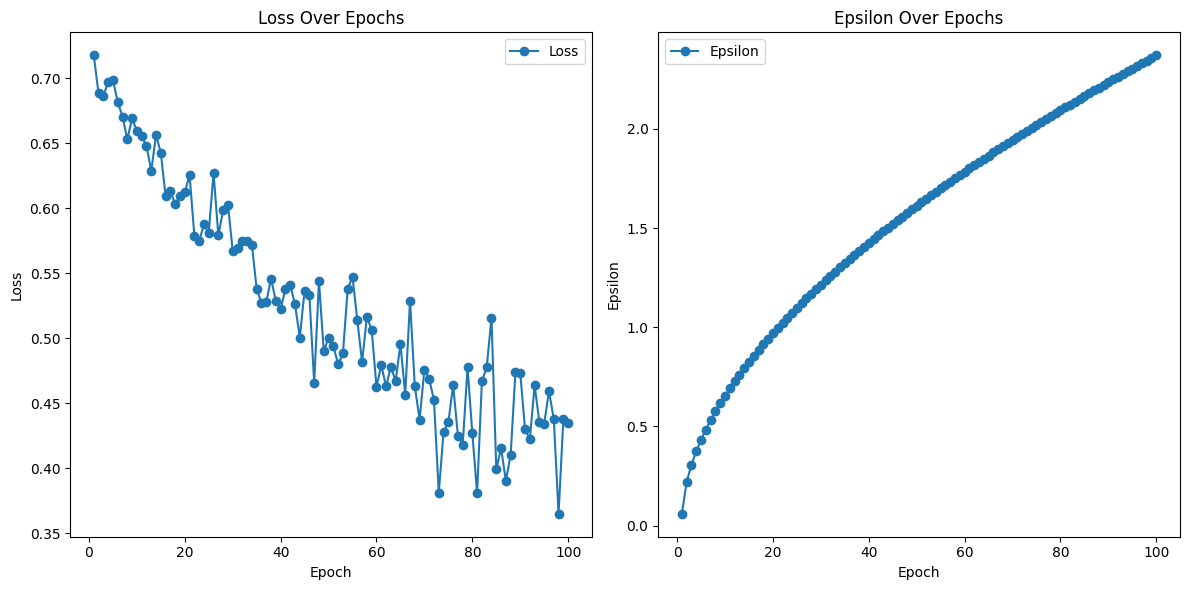

In [298]:
lossesLogDP,epsilons,y_predicted=logDP.train_model()
y_predicted_cls=logDP.predict_model(X_test)

### VIII. So sánh hiệu quả của các mô hình sau DP

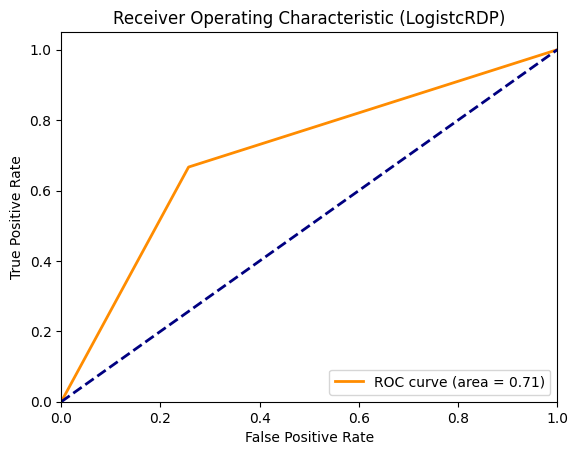

In [299]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_predicted_cls.cpu())

# Tính AUC
roc_auc = metrics.auc(fpr, tpr)

# Vẽ đường ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (LogistcRDP)')
plt.legend(loc="lower right")
plt.savefig("../static/app/images/ROCLogisticRegressionDP.png")
plt.show()

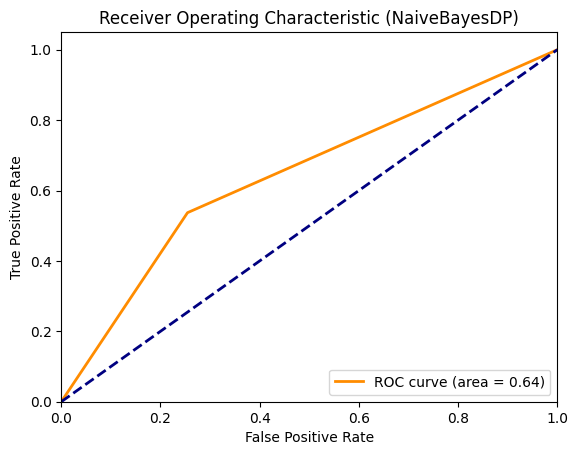

In [300]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, yResultNaive1)

# Tính AUC
roc_auc = metrics.auc(fpr, tpr)

# Vẽ đường ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (NaiveBayesDP)')
plt.legend(loc="lower right")
plt.savefig("../static/app/images/ROCNaiveBayesDP.png")
plt.show()

In [305]:
logResultDP =evaluateModel(y_test,y_predicted_cls.cpu())
model_names = ['LogR', 'LogRDP', 'NaiveB', 'NaiveBDP']
# Kết quả của hàm evaluateModel cho từng model
results = [
    logResult,logResultDP,NaiveResult,NaiveResult1
]
# Tạo DataFrame từ kết quả
df_results = pd.DataFrame(results, index=model_names)
from tabulate import tabulate
table = tabulate(df_results, headers='keys', tablefmt='pretty', showindex=True)
print(table)

auc_score = 0.7050194414987627
F1_score = 0.21686746987951808
Recall = 0.6666666666666666
Precision = 0.12949640287769784
+----------+--------------------+---------------------+--------------------+---------------------+
|          |   roc_auc_score    |      F1_score       |       Recall       |      Precision      |
+----------+--------------------+---------------------+--------------------+---------------------+
|   LogR   | 0.6073210007462393 | 0.21768707482993196 | 0.2962962962962963 | 0.17204301075268819 |
|  LogRDP  | 0.7050194414987627 | 0.21686746987951808 | 0.6666666666666666 | 0.12949640287769784 |
|  NaiveB  | 0.6375535132162917 | 0.17575757575757575 | 0.5370370370370371 | 0.10507246376811594 |
| NaiveBDP | 0.6412650720710107 | 0.17956656346749225 | 0.5370370370370371 | 0.10780669144981413 |
+----------+--------------------+---------------------+--------------------+---------------------+


### IX. Phân tích và ứng dụng mô hình tiềm năng nhất

1. Sự thay đổi về độ riêng tư và hàm mất mát trước và sau khi áp dụng DP 

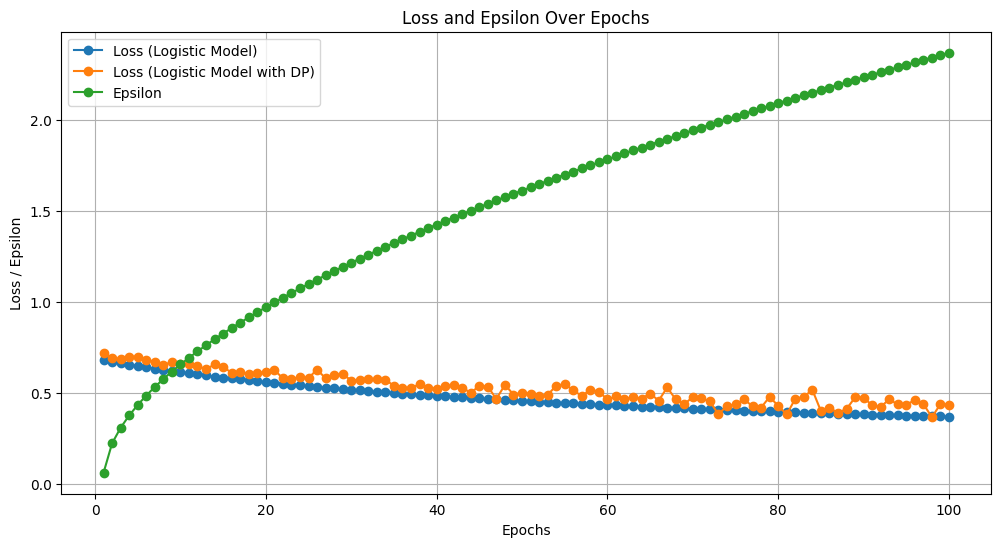

In [302]:
compare= lossesLog.__len__()
if lossesLog.__len__() > lossesLogDP.__len__():
    compare = lossesLogDP.__len__()
else:
    compare = lossesLog.__len__()
# Plotting loss over epochs
plt.figure(figsize=(12, 6))

plt.plot(range(1, compare+1), lossesLog[0:compare], label='Loss (Logistic Model)', marker='o')
plt.plot(range(1, compare+1), lossesLogDP[0:compare], label='Loss (Logistic Model with DP)', marker='o')
plt.plot(range(1, compare+1), epsilons[0:compare], label='Epsilon', marker='o')

plt.title('Loss and Epsilon Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss / Epsilon')
plt.legend()
plt.grid(True)
plt.savefig("../static/app/images/CompareOldAndNewModel.png")
plt.show()

2. Áp dụng mô hình vào dự đoán dữ liệu thực tế

In [303]:
data_single_person = {
    'gender': [1],
    'age': [40],
    'hypertension': [1],
    'heart_disease': [1],
    'ever_married': [1],
    'Residence_type': [1],
    'avg_glucose_level': [260],
    'bmi': [26.0],
    'work_type_Govt_job': [0],
    'work_type_Private': [1],
    'work_type_Self-employed': [0],
    'work_type_children': [0],
    'smoking_status_Unknown': [0],
    'smoking_status_formerly smoked': [0],
    'smoking_status_never smoked': [0],
    'smoking_status_smokes': [1]
}

df_single_person = pd.DataFrame(data_single_person)
df_single_person=sc.transform(df_single_person)
df_single_person=torch.from_numpy(df_single_person.astype(np.float32))
dp_model = LogisticRegression(num_features)
dp_model.model=torch.load('./StruckPredict.pth')
dp_model.eval()
prediction2 = dp_model(torch.tensor(df_single_person))
prediction2 = prediction2.round()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17548\4056345809.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction2 = dp_model(torch.tensor(df_single_person))


In [304]:
if prediction2.item() ==0:
    print("Xin chúc mừng bạn không có nguy cơ bị đột quỵ")
else:
    print("Bạn có khả năng bị đột quỵ, vui lòng chú ý sức khoẻ!")

Bạn có khả năng bị đột quỵ, vui lòng chú ý sức khoẻ!
